### Load necessary libraries

In [1]:
from petclassifier import processdata, models, output, figures
import uproot
import uproot_methods
import numpy as np
import matplotlib.pyplot as plt
seed = 11
np.random.seed(seed)

### Set up tenforlow (multiple CPU)

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, LSTM, Dense, Activation, Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, TimeDistributed
from tensorflow.keras import utils
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(device_count={'GPU': 0, 'CPU': 6}, log_device_placement=False ))

### Parameters to specify

In [3]:
FILE_NAME = 'extended_geomtery' # file name to load
NEIGHBOURS = 8 # add how many events should be processed around classified event
FOLDER_NAME = 'LSTMv1' # name of the folder (in saved_models) where output will be stored
PATH = 'saved_models/'+FOLDER_NAME
output.create_output_folder(PATH)
NUM_CATEGORIES = 5

Folder saved_models/LSTMv1 exists ! Moved to saved_models/backup
Successfully created the directory saved_models/LSTMv1 


### Load data

In [4]:
fileIn = uproot.open('data/'+FILE_NAME+'.root')
tree = fileIn["T"]

### Look at data

In [5]:
import importlib
importlib.reload(figures)

<module 'petclassifier.figures' from '/home/daria/documents_origins/Office_JPET/projects/PET_event_classification/petclassifier/petclassifier/figures.py'>

In [6]:
prompt, back_to_back, three_gamma, phantom_scatt, det_scatt = processdata.get_df_raw_data(
    tree, NUM_CATEGORIES)

--- load from file     :  0.15394806861877441 seconds ---
--- data manipulations :  0.023111820220947266 seconds ---


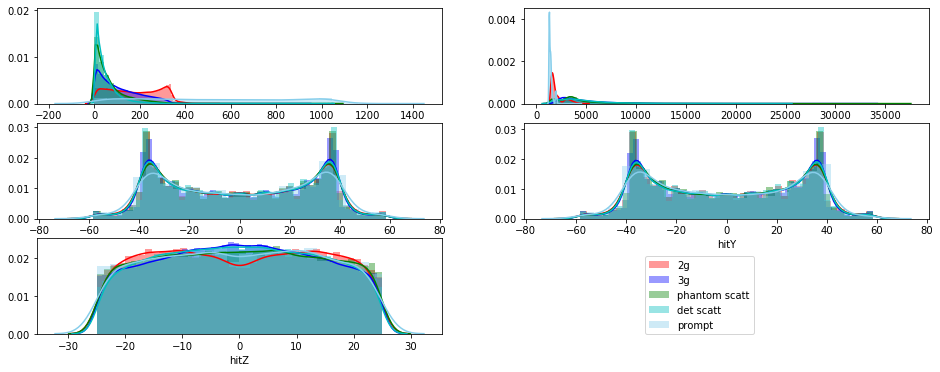

In [7]:
figures.plot_comparison(PATH,back_to_back, three_gamma, phantom_scatt, det_scatt, prompt)

### Analysis plan

Used analysis scheme:
- event to classity is surrounded by X neighbourgs on both sides
- this structure is passed to LSTM layer

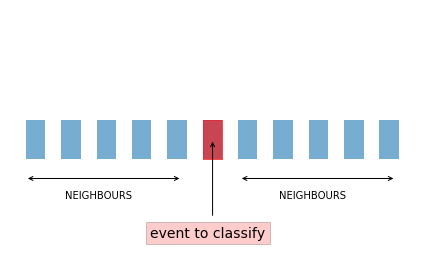

In [8]:
figures.event_scheme(PATH)

### Prepare data

In [9]:
import importlib
importlib.reload(processdata)

<module 'petclassifier.processdata' from '/home/daria/documents_origins/Office_JPET/projects/PET_event_classification/petclassifier/petclassifier/processdata.py'>

In [10]:
x_all, y_all = processdata.prepare_mc_sliding_window(
    tree, NEIGHBOURS, NUM_CATEGORIES)

--- load from file     :  0.16701030731201172 seconds ---
--- data manipulations :  6.11492919921875 seconds ---


### Split into train and test sets

In [11]:
train_size = int(len(x_all) * 0.67)
test_size = len(x_all) - train_size

x_train, x_test = x_all[0:train_size,:], x_all[train_size:len(x_all),:]
y_train, y_test = y_all[0:train_size,:], y_all[train_size:len(y_all),:]

### Prepare model

In [12]:
model = models.LSTMv2(x_train.shape[1:], NUM_CATEGORIES)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 600)               1454400   
_________________________________________________________________
dropout (Dropout)            (None, 600)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               180300    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5

In [13]:
EPOCHS = 500
BATCH_SIZE = 256

In [14]:
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [15]:
MODEL_NAME = PATH+'/best_model.h5'
modelCheckpoint = keras.callbacks.ModelCheckpoint(MODEL_NAME,
                                                  monitor='val_accuracy', mode='max',
                                                  verbose=1, save_best_only=True)

### Train

In [16]:
H = model.fit(x_train,
              y_train,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              callbacks=[modelCheckpoint,earlyStopping],
              validation_data=(x_test, y_test))

Train on 246315 samples, validate on 121320 samples
Epoch 1/500
246272/246315 [============================>.] - ETA: 0s - loss: 1.2991 - accuracy: 0.4126
Epoch 00001: val_accuracy improved from -inf to 0.43127, saving model to saved_models/LSTMv1/best_model.h5
246315/246315 [==============================] - 114s 461us/sample - loss: 1.2991 - accuracy: 0.4126 - val_loss: 1.2605 - val_accuracy: 0.4313
Epoch 2/500
246272/246315 [============================>.] - ETA: 0s - loss: 1.1393 - accuracy: 0.5066
Epoch 00002: val_accuracy improved from 0.43127 to 0.58558, saving model to saved_models/LSTMv1/best_model.h5
246315/246315 [==============================] - 113s 457us/sample - loss: 1.1393 - accuracy: 0.5066 - val_loss: 1.0044 - val_accuracy: 0.5856
Epoch 3/500
246272/246315 [============================>.] - ETA: 0s - loss: 0.9227 - accuracy: 0.6274
Epoch 00003: val_accuracy improved from 0.58558 to 0.65366, saving model to saved_models/LSTMv1/best_model.h5
246315/246315 [===========

Epoch 25/500
246272/246315 [============================>.] - ETA: 0s - loss: 0.5220 - accuracy: 0.7921
Epoch 00025: val_accuracy improved from 0.78090 to 0.78106, saving model to saved_models/LSTMv1/best_model.h5
246315/246315 [==============================] - 111s 451us/sample - loss: 0.5220 - accuracy: 0.7921 - val_loss: 0.5538 - val_accuracy: 0.7811
Epoch 26/500
246272/246315 [============================>.] - ETA: 0s - loss: 0.5157 - accuracy: 0.7939
Epoch 00026: val_accuracy did not improve from 0.78106
246315/246315 [==============================] - 112s 453us/sample - loss: 0.5158 - accuracy: 0.7939 - val_loss: 0.6106 - val_accuracy: 0.7570
Epoch 27/500
246272/246315 [============================>.] - ETA: 0s - loss: 0.5079 - accuracy: 0.7970
Epoch 00027: val_accuracy improved from 0.78106 to 0.78224, saving model to saved_models/LSTMv1/best_model.h5
246315/246315 [==============================] - 109s 444us/sample - loss: 0.5079 - accuracy: 0.7970 - val_loss: 0.5517 - val_a

### plot the training loss and accuracy

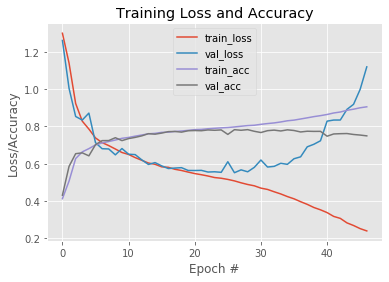

In [17]:
n_epochs = len(H.history['loss'])
N = np.arange(0, n_epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig(PATH+'/model_training.pdf', bbox_inches='tight')

In [18]:
model.load_weights(MODEL_NAME)
predictions = model.predict(x_test)

In [19]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))

accuracy: 78.25%
loss: 55.67%


In [20]:
expected = processdata.change_to_category(y_test)
predicted = processdata.change_to_category(predictions)

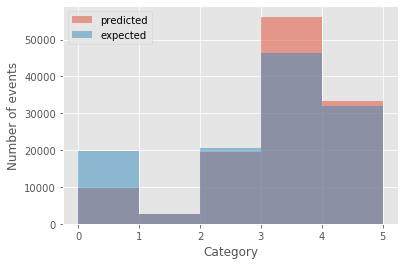

In [21]:
plt.hist(predicted, range=(0, NUM_CATEGORIES),
         bins=NUM_CATEGORIES, alpha=0.5, label='predicted')
plt.hist(expected, range=(0, NUM_CATEGORIES),
         bins=NUM_CATEGORIES, alpha=0.5, label='expected')
plt.legend()
plt.xlabel("Category")
plt.ylabel("Number of events")
plt.savefig(PATH+'/compare_categories.pdf', bbox_inches='tight')

Apperently, in some cases scatterings in the detector (category 0) are not changing gamma momentum significantly

In [22]:
from sklearn.metrics import confusion_matrix
results = confusion_matrix(expected, predicted)
results = results.astype('float') / results.sum(axis=1)[:, np.newaxis]
print(results)


[[2.75446067e-01 1.71330089e-02 7.31954582e-02 5.59154501e-01
  7.50709651e-02]
 [4.35571688e-02 7.07078040e-01 1.10707804e-01 1.36116152e-01
  2.54083485e-03]
 [3.67048099e-02 7.17610551e-03 7.64061288e-01 1.87403026e-01
  4.65477114e-03]
 [6.46766169e-02 2.07657365e-03 4.44300238e-02 8.77006273e-01
  1.18105127e-02]
 [1.00991152e-02 1.56333052e-04 9.06731701e-04 1.17875121e-02
  9.77050308e-01]]


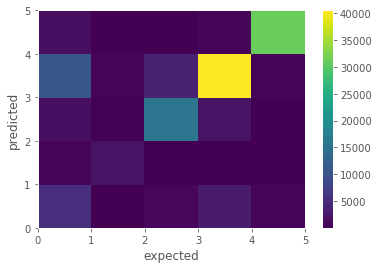

In [23]:
plt.hist2d(expected,predicted, bins=(NUM_CATEGORIES, NUM_CATEGORIES), range=[[0,NUM_CATEGORIES],[0,NUM_CATEGORIES]])
plt.xlabel('expected')
plt.ylabel('predicted')
plt.colorbar()
plt.show()